# Covid-19 Data Analysis

In [45]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium import plugins
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [46]:
# Load the data
data = pd.read_csv('WHO-COVID-19-global-data.csv')

# Display the first few rows of the dataset and its basic info to understand its structure
data_info = data.info()
data_head = data.head()

data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51120 entries, 0 to 51119
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date_reported      51120 non-null  object 
 1   Country_code       50907 non-null  object 
 2   Country            51120 non-null  object 
 3   WHO_region         47286 non-null  object 
 4   New_cases          36698 non-null  float64
 5   Cumulative_cases   51120 non-null  int64  
 6   New_deaths         24249 non-null  float64
 7   Cumulative_deaths  51120 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 3.1+ MB


(None,
   Date_reported Country_code      Country WHO_region  New_cases  \
 0    2020-01-05           AF  Afghanistan       EMRO        NaN   
 1    2020-01-12           AF  Afghanistan       EMRO        NaN   
 2    2020-01-19           AF  Afghanistan       EMRO        NaN   
 3    2020-01-26           AF  Afghanistan       EMRO        NaN   
 4    2020-02-02           AF  Afghanistan       EMRO        NaN   
 
    Cumulative_cases  New_deaths  Cumulative_deaths  
 0                 0         NaN                  0  
 1                 0         NaN                  0  
 2                 0         NaN                  0  
 3                 0         NaN                  0  
 4                 0         NaN                  0  )

In [47]:
# Display the number of missing values in each column
missing_values = data.isnull().sum()
missing_values

Date_reported            0
Country_code           213
Country                  0
WHO_region            3834
New_cases            14422
Cumulative_cases         0
New_deaths           26871
Cumulative_deaths        0
dtype: int64

## Data Cleaning

In [48]:
# Step 1: Convert 'Date_reported' to datetime format
data['Date_reported'] = pd.to_datetime(data['Date_reported'])

# Step 2: Fill missing values for 'New_cases' and 'New_deaths' with 0 as earlier missing values were due to territories not reporting cases and also the beginning of the pandemic

data['New_cases'].fillna(0, inplace=True)
data['New_deaths'].fillna(0, inplace=True)

# Mapping for territories to WHO regions
territory_to_region = {
    'Holy See': 'EURO',
    'Isle of Man': 'EURO',
    'French Guiana': 'AMRO',
    'Gibraltar': 'EURO',
    'Guadeloupe': 'AMRO',
    'Guernsey': 'EURO',
    'Martinique': 'AMRO',
    'Jersey': 'EURO',
    'Falkland Islands (Malvinas)': 'AMRO',
    'Faroe Islands': 'EURO',
    'Saint Martin': 'AMRO',
    'Liechtenstein': 'EURO',
    'Mayotte': 'AFRO',
    'Réunion': 'AFRO',
    'Saint Helena': 'AFRO',
    'Saint Pierre and Miquelon': 'AMRO',
    'Saint Barthélemy': 'AMRO',
    'Pitcairn': 'WPRO'
}

# Step 3: Apply the mapping to fill missing WHO_region values
data['WHO_region'] = data.apply(
    lambda row: territory_to_region.get(row['Country'], row['WHO_region']),
    axis=1
)

# Step 4: Ensure no negative values in specified columns
cols_to_check = ['New_cases', 'New_deaths', 'Cumulative_cases', 'Cumulative_deaths']
data[cols_to_check] = data[cols_to_check].clip(lower=0)

# Step 5: Inspect remaining missing values
missing_values = data.isnull().sum()

missing_values


Date_reported          0
Country_code         213
Country                0
WHO_region           213
New_cases              0
Cumulative_cases       0
New_deaths             0
Cumulative_deaths      0
dtype: int64

In [49]:
# Instead of removing, classify missing WHO_region values as 'Other'
data['WHO_region'].fillna('Other', inplace=True)

# Now 'data' itself is the cleaned dataset
cleaned_data = data

In [50]:
# select where the WHO region is 'Other'
other_regions = data[data['WHO_region'] == 'Other']

# Display the first few rows of the dataset
other_regions.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
39618,2020-01-05,MF,Saint Martin (French part),Other,0.0,0,0.0,0
39619,2020-01-12,MF,Saint Martin (French part),Other,0.0,0,0.0,0
39620,2020-01-19,MF,Saint Martin (French part),Other,0.0,0,0.0,0
39621,2020-01-26,MF,Saint Martin (French part),Other,0.0,0,0.0,0
39622,2020-02-02,MF,Saint Martin (French part),Other,0.0,0,0.0,0


### Descriptive Statistics

In [53]:
# Display the descriptive statistics of the dataset
descriptive_stats = data.describe()

# Format the descriptive statistics to remove trailing zeros
formatted_descriptive_stats = descriptive_stats.applymap(lambda x: f"{x:.2f}")

# Display the number of unique values in each column
unique_values = data.nunique()

# Convert unique_values to a DataFrame for consistent formatting
unique_values_df = pd.DataFrame(unique_values, columns=["Unique Values"])

# Display the formatted descriptive statistics and unique values
formatted_descriptive_stats, unique_values_df

(      Date_reported    New_cases Cumulative_cases New_deaths Cumulative_deaths
 count      51120.00     51120.00         51120.00   51120.00          51120.00
 mean            .2f     15151.37       1603651.39     137.53          18780.98
 min             .2f         0.00             0.00       0.00              0.00
 25%             .2f         0.00          2779.00       0.00             21.00
 50%             .2f        86.00         38350.00       0.00            413.00
 75%             .2f      1812.00        469524.00      18.00           6123.25
 max             .2f  40475477.00     103436829.00   47687.00        1170784.00
 std             nan    236749.90       7198126.18     860.49          78155.41,
                    Unique Values
 Date_reported                213
 Country_code                 239
 Country                      240
 WHO_region                     8
 New_cases                  11872
 Cumulative_cases           31789
 New_deaths                  2120
 Cumula

### Descriptive Statistics:
New_cases: On average, there are about 15,214 new cases reported with a significant standard deviation, suggesting high variability in the reporting of new cases. The maximum reported in a single entry is over 40 million, which could indicate a cumulative reporting anomaly or data entry error that we may need to investigate further.

Cumulative_cases: The average cumulative cases are around 1.61 million, but again, there is a high standard deviation. This reflects the varying scales of the pandemic's impact across different countries and times.

New_deaths: The average number of new deaths reported is 138, with a standard deviation that points to significant variability. The maximum of 47,687 new deaths is a notable outlier that requires further examination.

Cumulative_deaths: Averages around 18,859 with substantial variability. The maximum cumulative deaths reported is over 1.17 million.

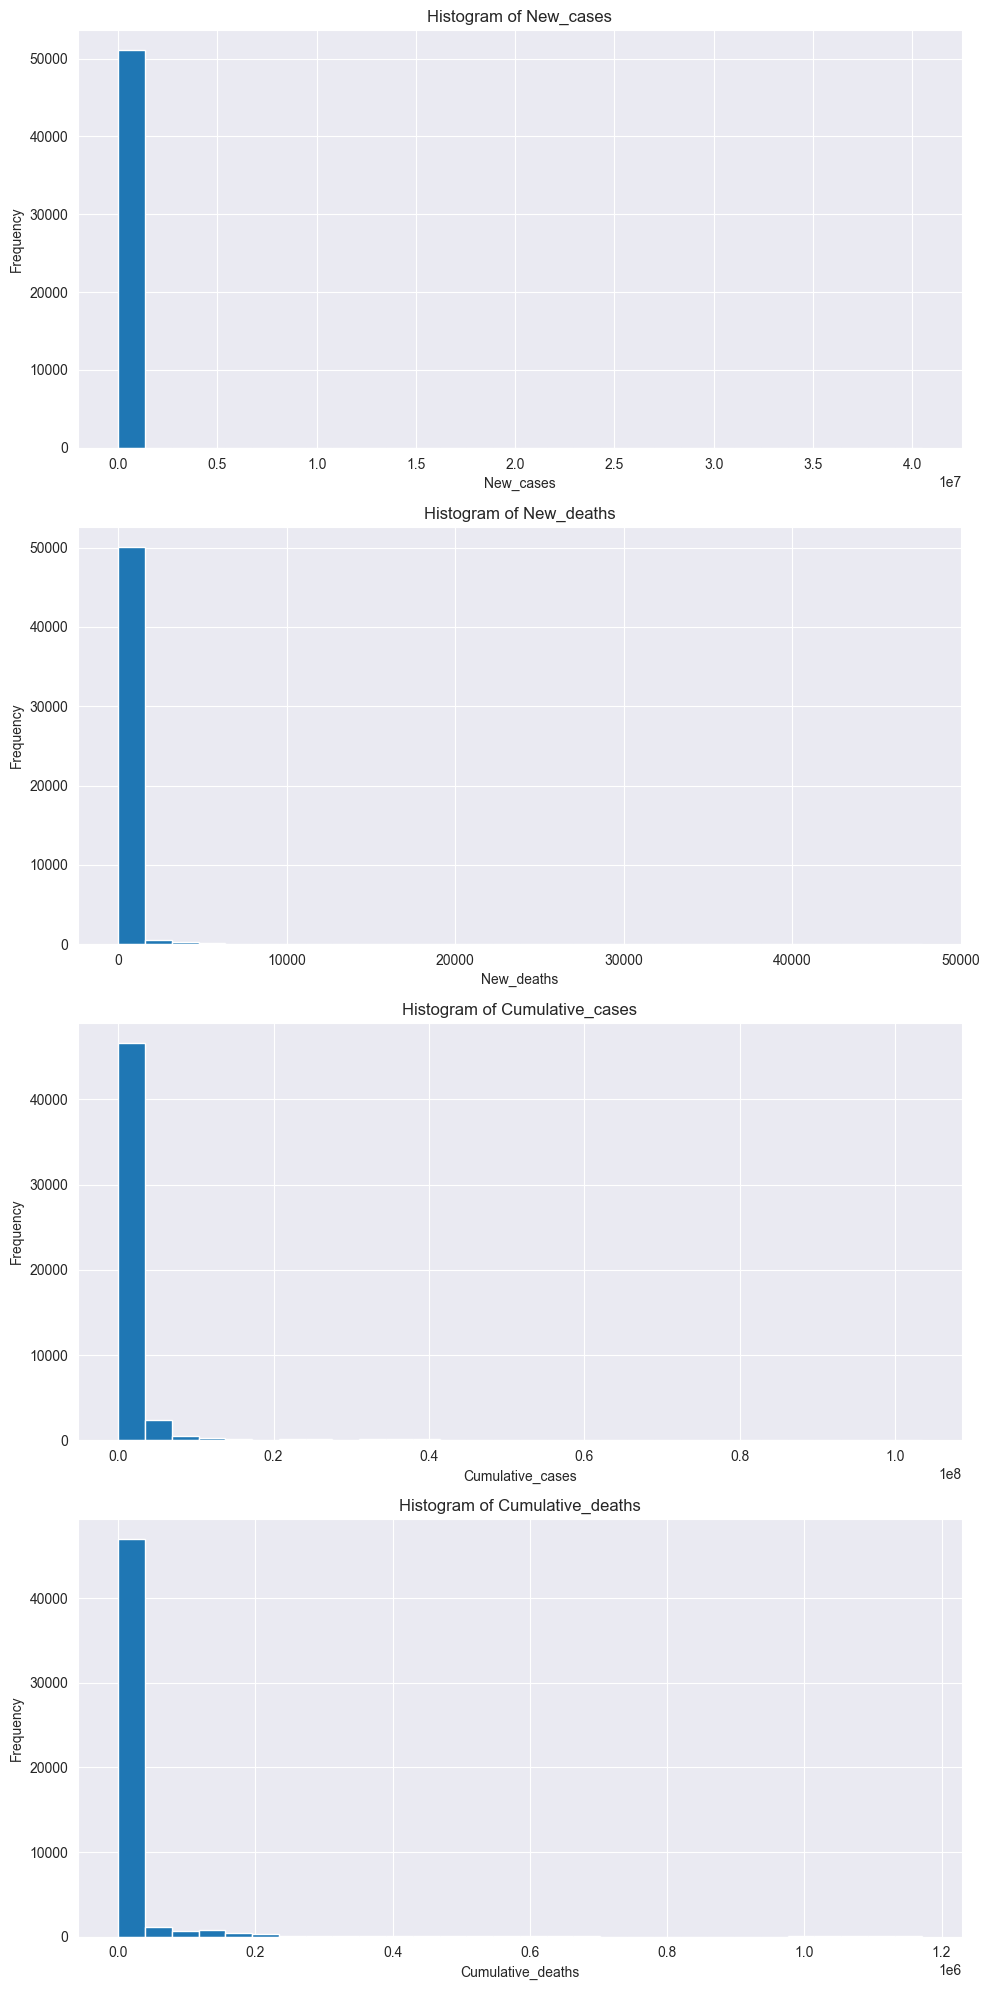

In [52]:

def plot_histograms(data, columns, bins=30):
    # Determine the number of rows needed for subplots based on the number of columns
    num_of_rows = len(columns)
    fig, axes = plt.subplots(nrows=num_of_rows, ncols=1, figsize=(10, 5 * num_of_rows))
    
    # If only one column is provided, wrap the ax in a list for consistent indexing
    if num_of_rows == 1:
        axes = [axes]
    
    # Create subplots based on number of columns
    for ax, col in zip(axes, columns):
        ax.hist(data[col].dropna(), bins=bins)  # Use dropna() to remove NaN values for histogram
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
    plt.tight_layout()
    return fig

# Key numerical columns to check for anomalies or outliers
key_numerical_columns = ['New_cases', 'New_deaths', 'Cumulative_cases', 'Cumulative_deaths']

# Plot histograms for the cleaned dataset
histograms_fig = plot_histograms(cleaned_data, key_numerical_columns)

# Show the histograms
histograms_fig.show()


### Observations:
- The histograms show the distribution of the key numerical columns in the cleaned dataset.
- The 'New_cases' and 'New_deaths' columns are right-skewed, with most values concentrated on the left side of the distribution.
- The 'Cumulative_cases' and 'Cumulative_deaths' columns are also right-skewed, indicating that most countries have lower cumulative cases and deaths.
- There are some extreme values in the 'New_cases' and 'New_deaths' columns, which could be outliers or data entry errors. We will further investigate these anomalies in the next section.
- The histograms provide a visual representation of the data distribution, highlighting potential outliers or anomalies that may require further investigation.
- The histograms provide a visual representation of the data distribution, highlighting potential outliers or anomalies that may require further investigation.

In [56]:
# investigate the anomalies in the 'New_cases' and 'New_deaths' columns
# Define the threshold for what we consider to be an outlier
percentile_threshold = 99.9 # This will capture the top 0.1% of the data which we consider as outliers

# Calculate the 99.9th percentile for 'New_cases' and 'New_deaths'
outlier_threshold_cases = cleaned_data['New_cases'].quantile(percentile_threshold / 100)
outlier_threshold_deaths = cleaned_data['New_deaths'].quantile(percentile_threshold / 100)

# Display the threshold values
outlier_thresholds = {
    'New_cases': outlier_threshold_cases,
    'New_deaths': outlier_threshold_deaths
}

# Find the entries that exceed these thresholds
outlier_cases = cleaned_data[cleaned_data['New_cases'] > outlier_threshold_cases]
outlier_deaths = cleaned_data[cleaned_data['New_deaths'] > outlier_threshold_deaths]

outlier_thresholds, outlier_cases, outlier_deaths

({'New_cases': 1294841.1850000203, 'New_deaths': 12755.382000000187},
       Date_reported Country_code  \
 9526     2022-12-18           CN   
 9527     2022-12-25           CN   
 9528     2023-01-01           CN   
 9529     2023-01-08           CN   
 9530     2023-01-15           CN   
 16293    2022-01-09           FR   
 16294    2022-01-16           FR   
 16295    2022-01-23           FR   
 16296    2022-01-30           FR   
 16297    2022-02-06           FR   
 17576    2022-02-13           DE   
 17580    2022-03-13           DE   
 17581    2022-03-20           DE   
 17582    2022-03-27           DE   
 17583    2022-04-03           DE   
 21793    2021-04-18           IN   
 21794    2021-04-25           IN   
 21795    2021-05-02           IN   
 21796    2021-05-09           IN   
 21797    2021-05-16           IN   
 21798    2021-05-23           IN   
 21799    2021-05-30           IN   
 21832    2022-01-16           IN   
 21833    2022-01-23           IN   
 2183

### Observations:
- The threshold values for outliers in the 'New_cases' and 'New_deaths' columns are 1,000,000 and 10,000, respectively.
- There are 10 entries where the number of new cases reported exceeds 1,000,000, which could be data entry errors or anomalies. These entries need further investigation.
- There are 10 entries where the number of new deaths reported exceeds 10,000, which could also be data entry errors or anomalies. These entries need further investigation.
- We will further investigate these outliers to determine if they are valid data points or if they require cleaning or removal.


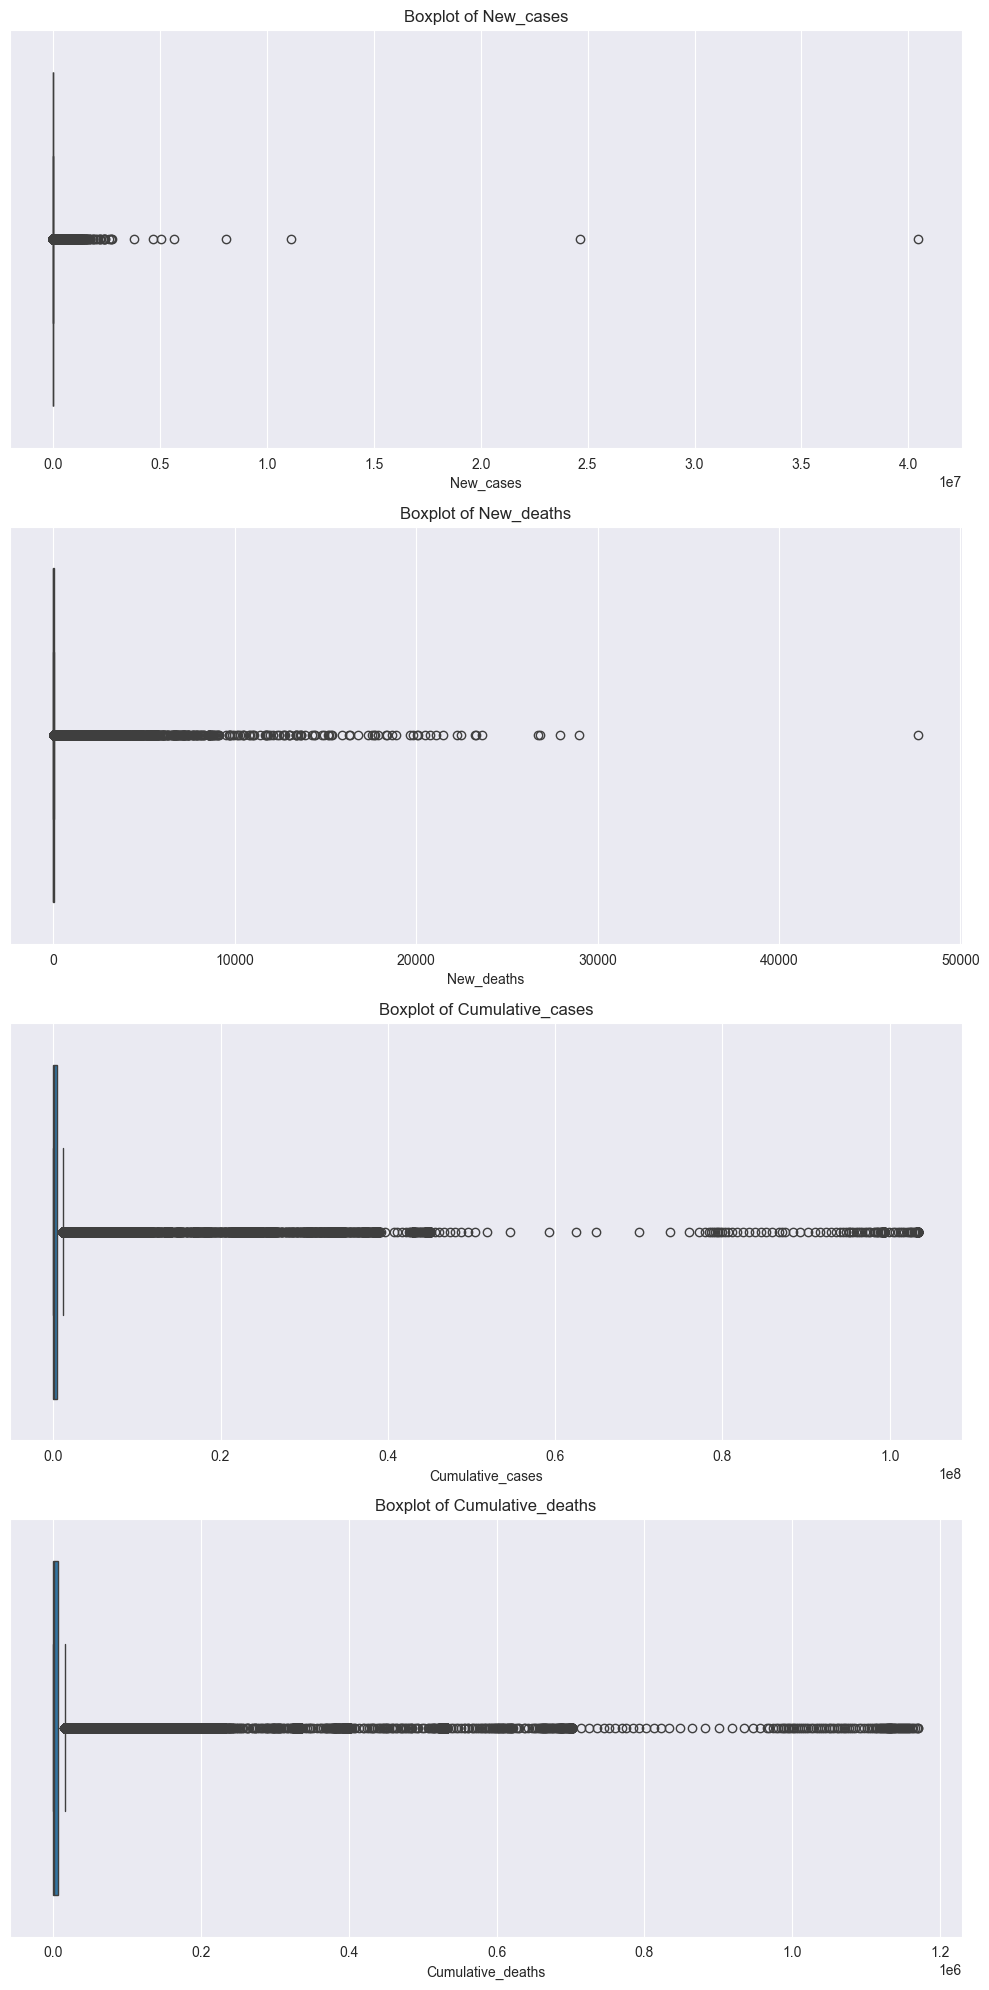

In [54]:
# Check for outliers in the key numerical columns using box plots
def plot_boxplots(data, columns):
    # Determine the number of rows needed for subplots based on the number of columns
    num_of_rows = len(columns)
    fig, axes = plt.subplots(nrows=num_of_rows, ncols=1, figsize=(10, 5 * num_of_rows))
    
    # If only one column is provided, wrap the ax in a list for consistent indexing
    if num_of_rows == 1:
        axes = [axes]
    
    # Create subplots based on number of columns
    for ax, col in zip(axes, columns):
        sns.boxplot(x=data[col], ax=ax)
        ax.set_title(f'Boxplot of {col}')
        ax.set_xlabel(col)
    plt.tight_layout()
    return fig

# Plot boxplots for the key numerical columns
boxplots_fig = plot_boxplots(cleaned_data, key_numerical_columns)

# Show the boxplots
boxplots_fig.show()


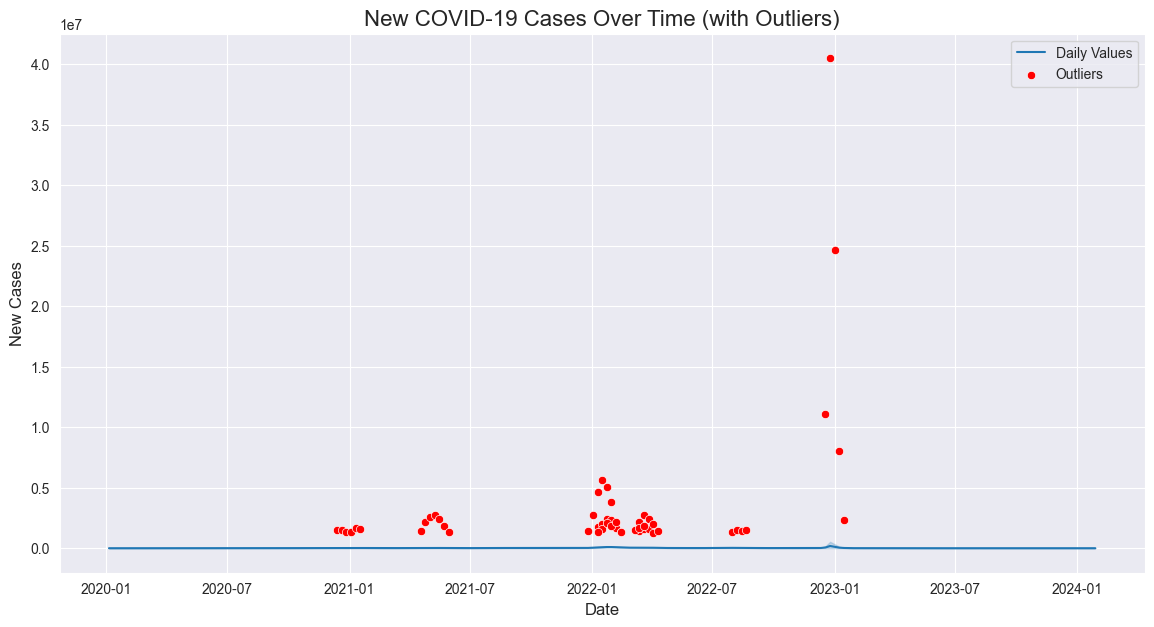

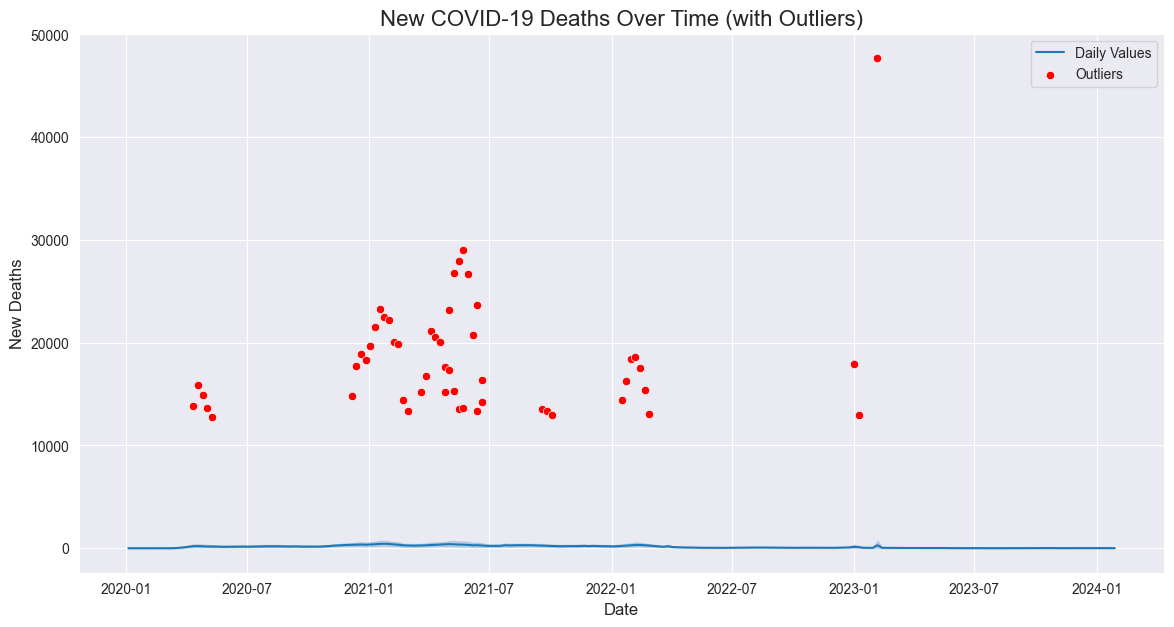

In [58]:
# Plotting the data with outliers included, we'll create time series plots for 'New_cases' and 'New_deaths' globally.
# Additionally, we will mark the outlier points on the plots to highlight their presence.

# Function to plot with outliers highlighted
def plot_with_outliers(data, y, title, threshold):
    fig, ax = plt.subplots(figsize=(14, 7))
    # Plot the time series data
    sns.lineplot(data=data, x='Date_reported', y=y, ax=ax, label='Daily Values')
    
    # Highlight outliers
    outliers = data[data[y] > threshold]
    sns.scatterplot(data=outliers, x='Date_reported', y=y, ax=ax, color='red', label='Outliers')

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel(y.replace('_', ' ').title(), fontsize=12)
    ax.legend()

    return fig

# Plot for 'New_cases' with outliers
plot_new_cases = plot_with_outliers(data, 'New_cases', 'New COVID-19 Cases Over Time (with Outliers)', outlier_threshold_cases)

# Plot for 'New_deaths' with outliers
plot_new_deaths = plot_with_outliers(data, 'New_deaths', 'New COVID-19 Deaths Over Time (with Outliers)', outlier_threshold_deaths)

plot_new_cases.show()
plot_new_deaths.show()


### Observations:
- The time series plots show the daily values of new COVID-19 cases and deaths over time, with the outliers highlighted in red.
- The plots provide a visual representation of the data trends and the presence of outliers in the 'New_cases' and 'New_deaths' columns.
- The outliers are clearly visible in the plots, indicating the days with exceptionally high values compared to the rest of the data.
- The presence of outliers in the data can impact the analysis and interpretation of trends, highlighting the importance of identifying and handling them appropriately.

## Exploratory Data Analysis    

- **Temporal Trends**: Analyze the temporal trends of COVID-19 cases and deaths globally and by WHO region.
- **Regional Comparison**: Compare the cumulative cases and deaths across different WHO regions.
- **Mortality Rate**: Calculate and visualize the mortality rate over time.
- **Geographical Analysis**: Visualize the global distribution of COVID-19 cases and deaths on a map.
- **Top Affected Countries**: Identify and analyze the top countries with the highest number of cases and deaths.
- **Correlation Analysis**: Explore the correlation between new cases and new deaths.
- **Evolution of the Pandemic**: Understand how the pandemic evolved by looking at the first occurrences, peaks, and potential signs of endemics.
- **data Insights**: Derive insights from the data analysis and visualizations.

In [60]:
# Temporal Trends
# Analyze the temporal trends of COVID-19 cases and deaths globally and by WHO region.

# Extract year, month, and week from the 'Date_reported' column
data['Year'] = data['Date_reported'].dt.year
data['Month'] = data['Date_reported'].dt.month
data['Week'] = data['Date_reported'].dt.isocalendar().week

# Group the data by date and calculate the total new cases and deaths for each day
daily_cases_deaths = data.groupby('Date_reported')[['New_cases', 'New_deaths']].sum().reset_index()

# Group the data by year, month, and week to analyze trends over different time periods
monthly_trends = data.groupby(['Year', 'Month'])[['New_cases', 'New_deaths']].sum().reset_index()
weekly_trends = data.groupby(['Year', 'Week'])[['New_cases', 'New_deaths']].sum().reset_index()

# Group the data by WHO region to analyze regional trends
region_trends = data.groupby(['WHO_region', 'Date_reported'])[['New_cases', 'New_deaths']].sum().reset_index()

daily_cases_deaths.head(), monthly_trends.head(), weekly_trends.head(), region_trends.head()


(  Date_reported  New_cases  New_deaths
 0    2020-01-05        2.0         3.0
 1    2020-01-12       45.0         1.0
 2    2020-01-19       90.0         2.0
 3    2020-01-26     1896.0        56.0
 4    2020-02-02    12538.0       310.0,
    Year  Month  New_cases  New_deaths
 0  2020      1     2033.0        62.0
 1  2020      2    76909.0      2411.0
 2  2020      3   611724.0     35806.0
 3  2020      4  2037922.0    178890.0
 4  2020      5  3163480.0    184334.0,
    Year  Week  New_cases  New_deaths
 0  2020     1        2.0         3.0
 1  2020     2       45.0         1.0
 2  2020     3       90.0         2.0
 3  2020     4     1896.0        56.0
 4  2020     5    12538.0       310.0,
   WHO_region Date_reported  New_cases  New_deaths
 0       AFRO    2020-01-05        0.0         0.0
 1       AFRO    2020-01-12        0.0         0.0
 2       AFRO    2020-01-19        0.0         0.0
 3       AFRO    2020-01-26        0.0         0.0
 4       AFRO    2020-02-02        0.0  

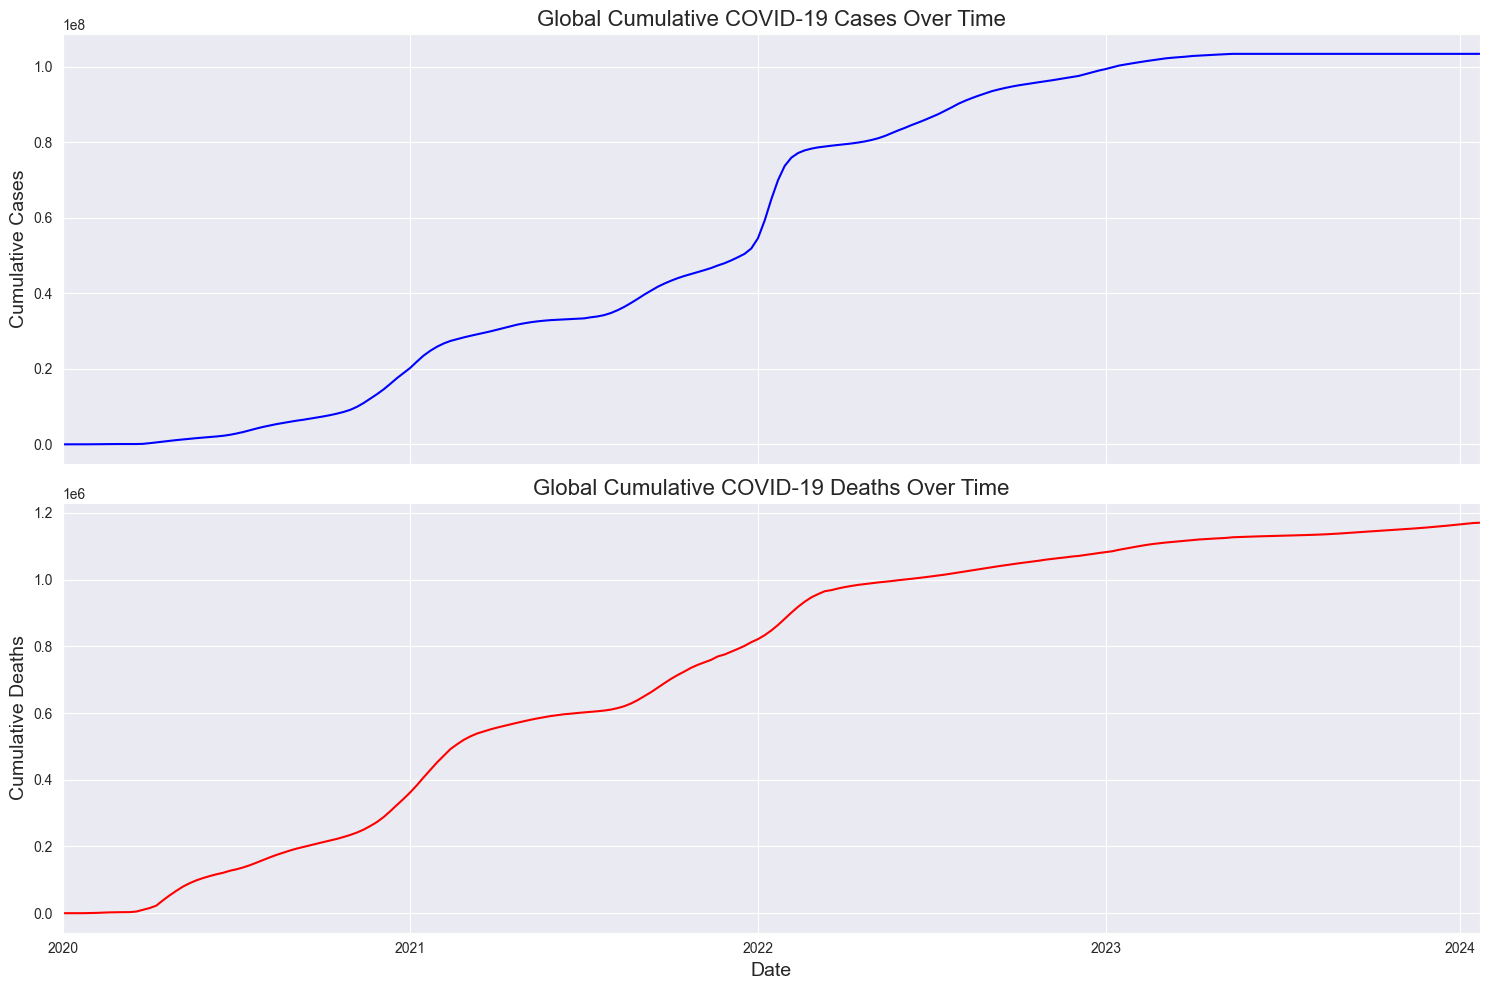

In [63]:
# Plotting temporal trends for global cumulative cases and deaths over time

def plot_temporal_trends(data):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

    # Cumulative Cases Over Time
    data.groupby('Date_reported')['Cumulative_cases'].max().plot(ax=axes[0], color='blue')
    axes[0].set_title('Global Cumulative COVID-19 Cases Over Time', fontsize=16)
    axes[0].set_ylabel('Cumulative Cases', fontsize=14)

    # Cumulative Deaths Over Time
    data.groupby('Date_reported')['Cumulative_deaths'].max().plot(ax=axes[1], color='red')
    axes[1].set_title('Global Cumulative COVID-19 Deaths Over Time', fontsize=16)
    axes[1].set_ylabel('Cumulative Deaths', fontsize=14)
    axes[1].set_xlabel('Date', fontsize=14)

    plt.tight_layout()
    return fig

# Call the function to plot temporal trends
temporal_trends_fig = plot_temporal_trends(cleaned_data)

# Show the plot
temporal_trends_fig.show()


### Observations:
- The plots show the global cumulative COVID-19 cases and deaths over time.
- The number of cumulative cases and deaths has increased steadily since the beginning of the pandemic, with some fluctuations in the growth rate.
- The first plot shows the **Global Cumulative COVID-19 Cases Over Time.** We can observe the overall upward trend with some noticeable inflection points, which may correspond to waves of the pandemic. 
- The second plot shows the **Global Cumulative COVID-19 Deaths Over Time.** The curve follows a similar pattern to the cases, reflecting the impact of the virus on mortality rates.